# Advices and Gotchas when using cling and jupyter
The cling and xeus docs are good, but some informations are missing : this notebook adds more details.

Cling official docs: https://root.cern.ch/cling
* `.x filename.cxx` - loads filename and calls void filename() if defined
* `.L library | filename.cxx` - loads library or filename.cxx
* `.printAST` - shows the abstract syntax tree after each processed entity
* `.I path` - adds an include path

xeus-cling official docs: https://xeus-cling.readthedocs.io/en/latest/index.html
<a href="."><img src="data/all_notebooks.svg" align="right"></a>

# Some more advices / missing docs

## Add include path / And library path / load libraries

### Add library and include path
* `#pragma cling add_library_path("...")` will add a path to the library path
* `#pragma cling add_include_path("...")` will add a path to the include path

### Load libraries

`#pragma cling load("mylibrary")` will load a library. You do not need to add the library extension (`.so`, '`.lib`, or `.dylib`). You can also load a library using `.L`.

## Do not put a ";" at the end if you want to see the computation result
The cell below will output a result:

In [1]:
2*3

6

The cell below will not, because of the ending ";"

In [2]:
2*3;

## Create a .cpp or .h script in order to set your library/include path and load common libraries

See for example [init_stdlibs.h](init_stdlibs.h) or [init.opencv.cpp](init.opencv.cpp)

Below is an example usage:

In [3]:
#include "init_stdlibs.h"
#include "init.opencv.cpp"

## This is C++ : everything can be defined only once

If you run twice a code that defines the same variable or a function, you will encounter a compiler error, with a bad looking Red Error Message (*error: redefinition of '...'*). 

Several ways to work around this : 
1. Restart the compiler from scratch : select "Kernel/Restart" and re-run the different cells

2. Enclose the code contained in a cell in an anonymous code-block in order to create a closed scope 
for your variables: for example, a cell like the one below can be run several times:

In [4]:
{
  std::string s("Hello how are you");
  int nbspaces = count(s.begin(),s.end(),' ');
  std::cout << "nbspaces=" << nbspaces << "\n";
}

nbspaces=3


3. Alternatively, use Immediately Invoked/Executed Lambdas (IIL), for example:  `const auto your_var = []{ YourCodeHere; return something; }();`

*Note*: Immediately Executed Lambdas are similar to the javascript idiom [immediately invoked function expression (IIFE)](https://en.wikipedia.org/wiki/Immediately_invoked_function_expression).

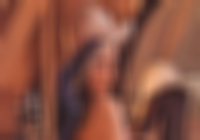

In [5]:
[] { // This is the start of the Immediately Invoked Lambda 
     // (the "()" can be avoided, since it does not have params)
  cv::Mat m = cv::imread("data/lena.jpg"), blur;
  cv::resize(m, m, cv::Size(200, 140));
  cv::blur(m, blur, cv::Size(15, 15));
  return im::show(blur);
}() 
// * note the "()" on the last line: it immediately invokes 
//   the lambda (hence the IIL name)
// * Also note that the ending ";" is missing, so that the 
//   last computation result will be shown in the notebook

# Some gotchas with cling and jupyter

## Do not define two functions in the same cell
### Failure example
this cell will give an error : "function definition is not allowed here"

In [6]:
int foo() { return 42; }
int foo2() {return 43; }

input_line_17:3:13: error: function definition is not allowed here
 int foo2() {return 43; }
            ^


Interpreter Error: 

### Correction
Create two cells

In [7]:
int foo() { return 42; }

In [8]:
int foo2() {return 43; }

## Add ";;" after lambdas

### Failure example
If you run the two cells below, the notebook "Kernel" will fail, and you will need to restart it (menu "Kernel / Restart")

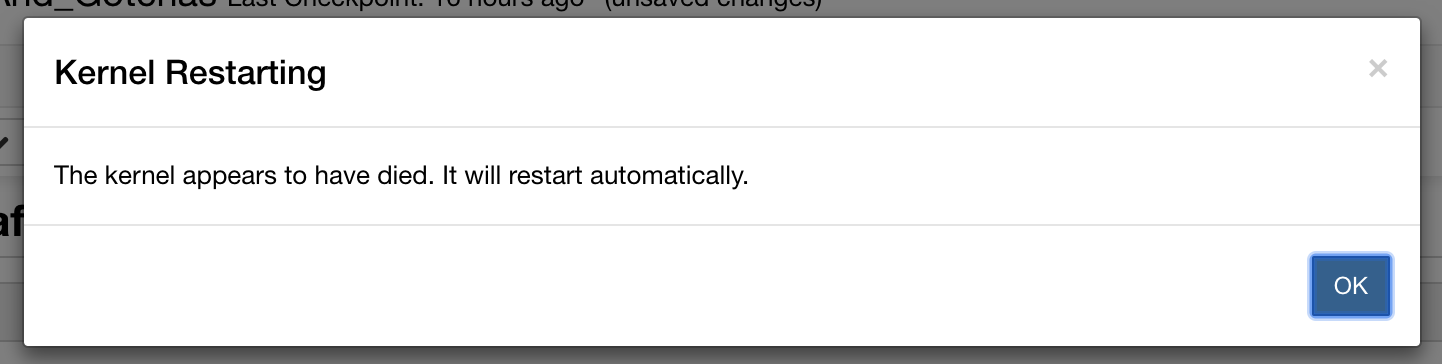

In [9]:

auto same = [](int i) { return i; }; // need to add a second ";" !

In [ ]:
same(1)

### Correction: add ";;" after the lambda

In [9]:
// Strangely it will work with ";;"
auto same = [](int i) { return i; };;

In [10]:
same(1)

1

## higher order functions : pass input functions by universal reference
### Failure example : passing input function by copy

In [11]:
int add1(int i) { return i + 1; }

In [12]:
// This higher order function capture its input function (f) by copy
auto call_twice = [] (auto f) {
    return [&](auto x) {
      return f(f(x)); 
    };
};;

In [13]:
auto add2 = call_twice(add1);;

In [ ]:
// this call will cause the kernel to fail
add2(2);

### Correction : pass the param via universal reference (&&)

In [1]:
int add1(int i) { return i + 1; }

In [2]:
// This higher order function capture its input by universal reference (&&)
auto call_twice = [] (auto && f) {
    return [&](auto x) {
      return f(f(x)); 
    };
};;

In [3]:
auto add2 = call_twice(add1);;

In [4]:
add2(2)

4

# When running cling from the console 

## Command line arguments (when using cling from the console)

cling is a version of `clang` that includes REPL.
Thus, it accepts the standard `clang` command line arguments.

For example:
````
cling -I/opt/include -Lopencv_core --std=c++14
````





## Add `using namespace std`

If you try to display a `std::string` or a `std::vector<std::string>` you might get some errors like this inside cling, when you are on the console (not inside notebook)
````
error: no template named 'basic_string'; did you mean 'std::basic_string'?
````

You can solve this by adding a line `using namespace std`